## Using Dataset: [healthcare_dataset](https://www.kaggle.com/datasets/prasad22/healthcare-dataset)

我先匯入資料並處理日期型別的問題，將他們轉換成 pd datetime

In [17]:
import pandas as pd
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

df = pd.read_csv('healthcare_dataset.csv')

# Convert date columns to datetime
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])

# Convert date columns to number of days since the minimum date
min_date = min(df['Date of Admission'].min(), df['Discharge Date'].min())
df['Date of Admission'] = (df['Date of Admission'] - min_date).dt.days
df['Discharge Date'] = (df['Discharge Date'] - min_date).dt.days


接下對他們作前處理

In [18]:
categorical_features = ['Name', 'Gender', 'Blood Type', 'Medical Condition', 'Doctor', 'Hospital', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']

for feature in categorical_features:
    le = LabelEncoder()  # create a new LabelEncoder for each feature
    df[feature] = le.fit_transform(df[feature])

然後將資料做 train test split, 目標是要預測 Medical Condition

In [19]:
# Split the dataset into features and target
X = df.drop('Medical Condition', axis=1) # predict Medical Condition
y = df['Medical Condition']

然後對資料做 cross-validation (ShuffleSplit)

In [20]:
# Cross-validation
ssplit = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

用 Decision Tree Classifier 訓練出我的模型並做出 prediction. 最後再 print 出 accuracy score

In [21]:
for train_index, test_index in ssplit.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.1672
Accuracy: 0.1712
Accuracy: 0.1664
Accuracy: 0.168
Accuracy: 0.1692


因為 ROC 和 precision recall curve 比較適合用在 binary classification problem, 所以要經過一些處理才能畫出 precision recall curve.

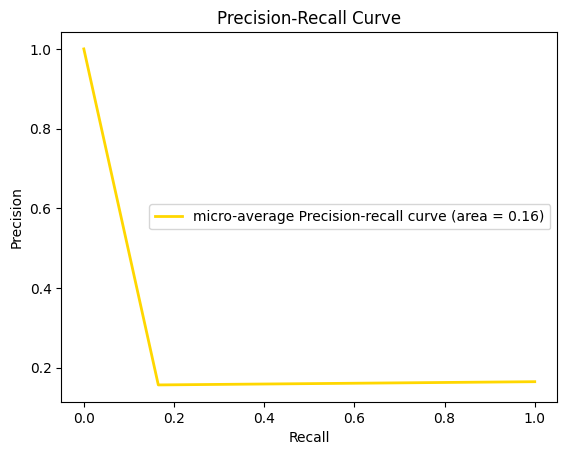

In [31]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
from itertools import cycle
# Use label_binarize to be multi-label like settings
Y_test = label_binarize(y_test, classes=[0, 1, 2]).reshape(-1, 1)
Y_pred = label_binarize(y_pred, classes=[0, 1, 2]).reshape(-1, 1)
n_classes = Y_test.shape[1]

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], Y_pred[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], Y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(), Y_pred.ravel())
average_precision["micro"] = average_precision_score(Y_test, Y_pred, average="micro")

# Plot the micro-averaged Precision-Recall curve
plt.figure()
plt.plot(recall["micro"], precision["micro"], color='gold', lw=2,
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="right")
plt.title('Precision-Recall Curve')

plt.show()

根據這個圖看起來預測結果是慘不忍睹.  

Ideal curve:  
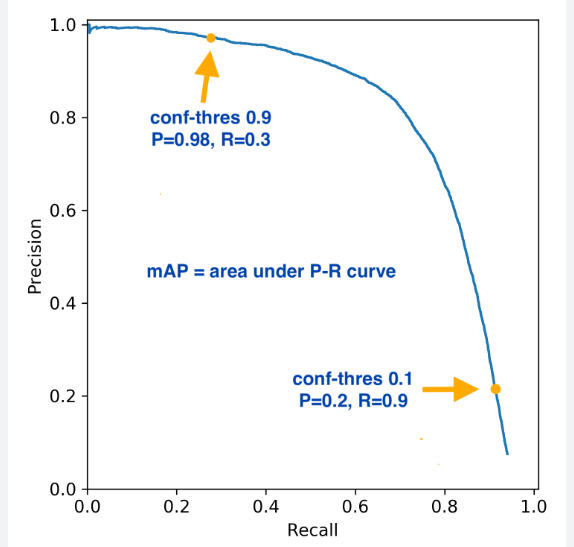